In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from dask.distributed import Client
import numpy as np
import pandas as pd
import glob

In [2]:
client = Client()

In [3]:
client

<Client: 'tcp://127.0.0.1:36627' processes=7 threads=14, memory=63.00 GiB>

## Workflow to generate the below data
* Run the sea breeze identification (`barra_c/filter_jobs/filter_F_driver.sh`)
* Resample to daily max (in local time) and define SB days for each REZ (`composite_analysis/daily_resample.sh`)
* Composite variables for SB days and non SB days in a set of regions, on a monthly basis, and average to seasonal (`sea_breeze_composite_*.sh`)

In [4]:
def load_composite(region):

    sb = []
    nonsb = []
    for season in ["ANN","DJF","MAM","JJA","SON"]:
        sb.append(xr.open_dataset("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_sb_composite_"+region+"_"+season+".nc",chunks={}))
        nonsb.append(xr.open_dataset("/g/data/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_nonsb_composite_"+region+"_"+season+".nc",chunks={}))
    
    sb = xr.concat(sb,dim="season").persist()
    nonsb = xr.concat(nonsb,dim="season").persist()
    
    sb["season"] = ["ANN","DJF","MAM","JJA","SON"]
    nonsb["season"] = ["ANN","DJF","MAM","JJA","SON"]

    return sb, nonsb

gipps_sb, gipps_non_sb = load_composite("gipps")
bunbury_sb, bunbury_non_sb = load_composite("bunbury")
illawarra_sb, illawara_non_sb = load_composite("illawara")
newcastle_sb, newcastle_non_sb = load_composite("newcastle")
sa_sb, sa_non_sb = load_composite("sa")
southern_sb, southern_non_sb = load_composite("southern")
tas_sb, tas_non_sb = load_composite("tas")

In [5]:
shapes = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/rez_coastal_shapes.nc").sel(lat=gipps_sb.lat,lon=gipps_sb.lon)
shapes_bunbury = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/rez_coastal_shapes.nc").sel(lat=bunbury_sb.lat,lon=bunbury_sb.lon)

In [6]:
# shapes_bunbury.bunbury_landsea.plot()
# xr.plot.contour((shapes_bunbury["rez_mask"]==43))

#Gipps=27
#Illawarra=19
#Newcastle=18
#Southern=28
#SA=38
#Tas=42
#Bunbury=43

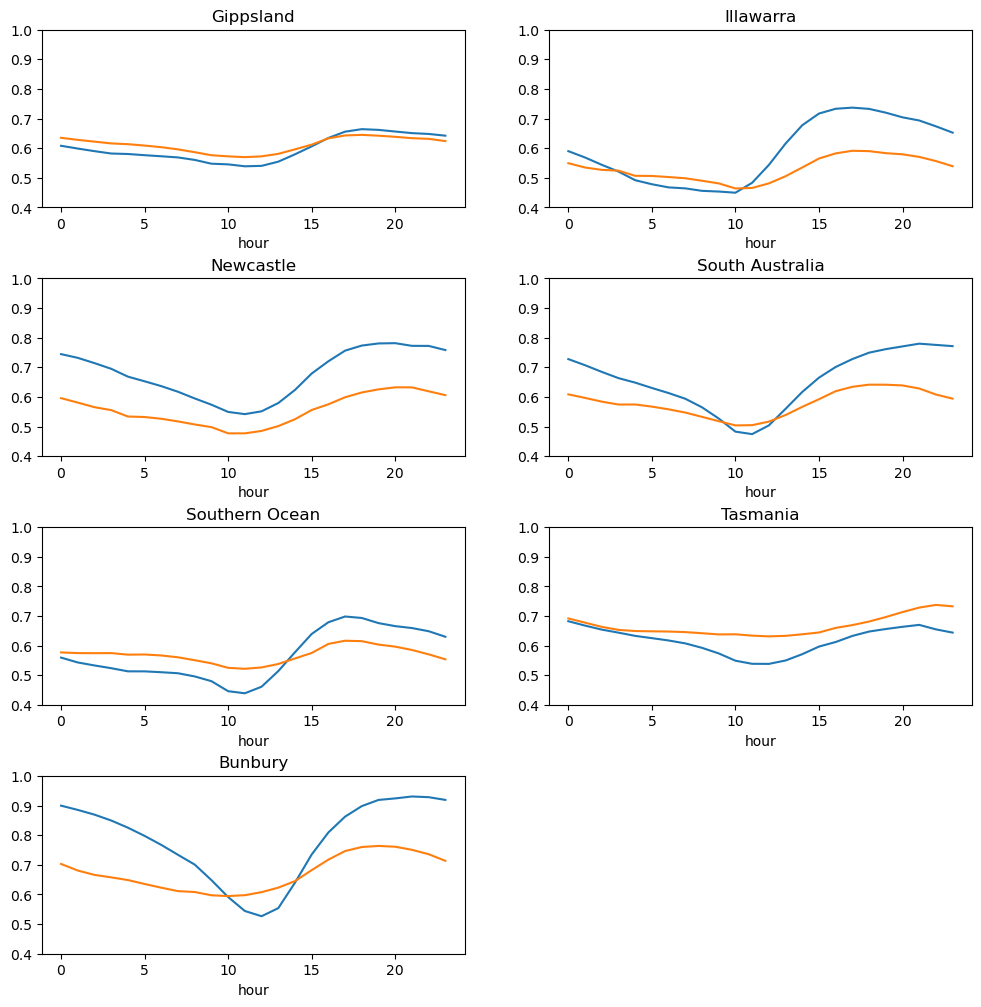

In [7]:
def plot(mask,sb,non_sb,var,season="DJF",title=""):
    xr.where(
        mask,
        sb.sel(season=season)[var],
        np.nan).mean(("lat","lon")).plot()
    xr.where(
        mask,
        non_sb.sel(season=season)[var],
        np.nan).mean(("lat","lon")).plot()
    plt.title(title)

    if var=="u":
        plt.ylim([-7,7])
    elif var=="v":
        plt.ylim([-12,12])
    elif var=="cf":
        plt.ylim([0.4,1])

plt.figure(figsize=[12,12])

plt.subplot(4,2,1)
plot(shapes["rez_mask"]==27, gipps_sb, gipps_non_sb, "cf",title="Gippsland")

plt.subplot(4,2,2)
plot(shapes["rez_mask"]==19, illawarra_sb, illawara_non_sb, "cf",title="Illawarra")

plt.subplot(4,2,3)
plot(shapes["rez_mask"]==18, newcastle_sb, newcastle_non_sb, "cf",title="Newcastle")

plt.subplot(4,2,4)
plot(shapes["rez_mask"]==38, sa_sb, sa_non_sb, "cf",title="South Australia")

plt.subplot(4,2,5)
plot(shapes["rez_mask"]==28, southern_sb, southern_non_sb, "cf",title="Southern Ocean")

plt.subplot(4,2,6)
plot(shapes["rez_mask"]==42, tas_sb, tas_non_sb, "cf",title="Tasmania")

plt.subplot(4,2,7)
plot(shapes_bunbury["rez_mask"]==43, bunbury_sb, bunbury_non_sb, "cf",title="Bunbury")


plt.subplots_adjust(hspace=0.4)

In [ ]:
def plot(mask,sb,var,season="DJF",title="",label=""):
    xr.where(
        mask,
        sb.sel(season=season)[var],
        np.nan).mean(("lat","lon")).plot(label=label)

    if var=="u":
        plt.ylim([-7,7])
    elif var=="v":
        plt.ylim([-12,12])
    elif var=="cf":
        plt.ylim([0.3,0.8])

    plt.title(title)

    plt.legend()

plt.figure(figsize=[12,4])

plt.subplot(1,2,1)
plot(shapes["rez_mask"]==19, illawarra_sb, "cf",title="Illawarra",label="Illawarra SB days")
plot(shapes["rez_mask"]==19, newcastle_sb, "cf",title="Illawarra",label="Newcastle SB days")
plot(shapes["rez_mask"]==19, gipps_sb, "cf",title="Illawarra",label="Gippsland SB days")
plot(shapes["rez_mask"]==19, tas_sb, "cf",title="Illawarra",label="Tasmania SB days")
plot(shapes["rez_mask"]==19, southern_sb, "cf",title="Illawarra",label="Southern Ocean SB days")
plot(shapes["rez_mask"]==19, sa_sb, "cf",title="Illawarra average capacity factor",label="South Australia SB days")


plt.subplot(1,2,2)
plot(shapes["rez_mask"]==28, illawarra_sb, "cf",title="",label="Illawarra")
plot(shapes["rez_mask"]==28, newcastle_sb, "cf",title="",label="Newcastle")
plot(shapes["rez_mask"]==28, gipps_sb, "cf",title="",label="Gippsland")
plot(shapes["rez_mask"]==28, tas_sb, "cf",title="",label="Tasmania")
plot(shapes["rez_mask"]==28, southern_sb, "cf",title="",label="Southern Ocean")
plot(shapes["rez_mask"]==28, sa_sb, "cf",title="Southern ocean average capacity factor",label="South Australia")

Text(0.5, 1.0, 'Illawarra other days 17:00 AEST')

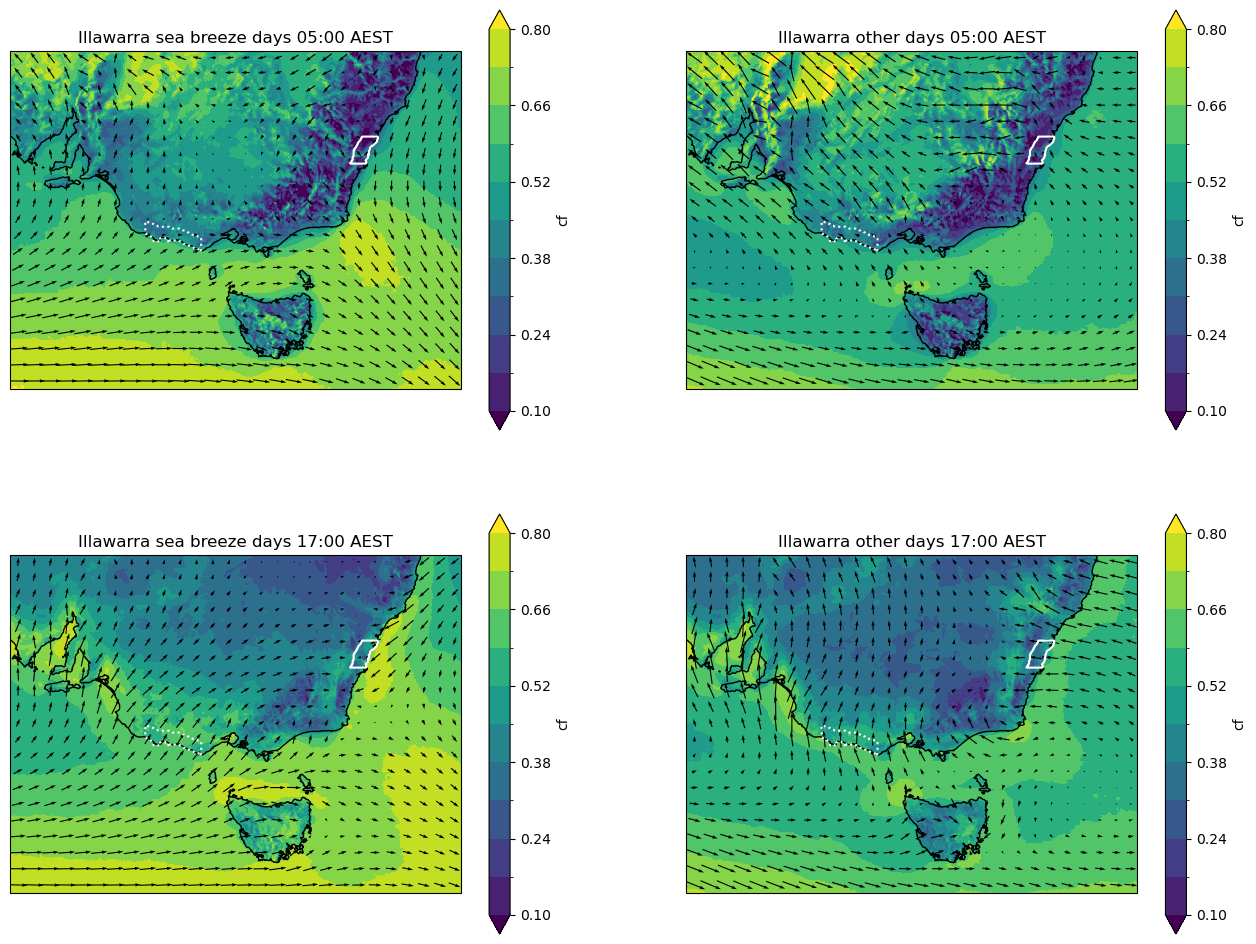

In [70]:
def plot_map(sb_avg,nonsb_avg,h,ax1,ax2,shapes,shape1,shape2,lat_slice=slice(-45,-30),lon_slice=slice(135,155),c=10):

    c=18
    
    if h == "mean":
        sb_avg = sb_avg.mean("hour")
        nonsb_avg = nonsb_avg.mean("hour")
    else:
        sb_avg = sb_avg.sel(hour=h)
        nonsb_avg = nonsb_avg.sel(hour=h)
    
    
    #sb_avg.sel(lat=lat_slice,lon=lon_slice).ws.plot(levels=np.linspace(4,12,11),ax=ax1,extend="both")
    sb_avg.sel(lat=lat_slice,lon=lon_slice).cf.plot(levels=np.linspace(0.1,0.8,11),ax=ax1,extend="both")
    #sb_avg.sel(lat=lat_slice,lon=lon_slice).tas.plot(levels=np.linspace(285,300,11),extend="both")
    sb_avg.sel(lat=lat_slice,lon=lon_slice).coarsen({"lat":c,"lon":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",ax=ax1)
    ax1.coastlines()

    xr.plot.contour(
        xr.where(shapes["lsm"],
                #(shapes["gipps_landsea"] +\
                #shapes["newcastle_landsea"] +\
                #shapes["illawara_landsea"] +\
                shapes[shape1],# +\
                #shapes["sa_landsea"] +\
                #shapes["tas_landsea"] +\
                #shapes["bunbury_landsea"]),
            0),
        levels=1,colors=["white"],linewidths=1.5,ax=ax1)
    xr.plot.contour(
        xr.where(shapes["lsm"],
                shapes[shape2],
            0),
        levels=1,colors=["white"],linewidths=1.5,linestyles=[":"],ax=ax1)    
    
    
    #nonsb_avg.sel(lat=lat_slice,lon=lon_slice).ws.plot(levels=np.linspace(4,12,11),ax=ax2,extend="both")
    nonsb_avg.sel(lat=lat_slice,lon=lon_slice).cf.plot(levels=np.linspace(0.1,0.8,11),ax=ax2,extend="both")
    #nonsb_avg.sel(lat=lat_slice,lon=lon_slice).tas.plot(levels=np.linspace(285,300,11),extend="both")
    nonsb_avg.sel(lat=lat_slice,lon=lon_slice).coarsen({"lat":c,"lon":c},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="u",v="v",ax=ax2)
    ax2.coastlines()

    xr.plot.contour(
        xr.where(shapes["lsm"],
                #(shapes["gipps_landsea"] +\
                #shapes["newcastle_landsea"] +\
                #shapes["illawara_landsea"] +\
                shapes[shape1],# +\
                #shapes["sa_landsea"] +\
                #shapes["tas_landsea"] +\
                #shapes["bunbury_landsea"]),
            0),
        levels=1,colors=["white"],linewidths=1.5,ax=ax2)
    xr.plot.contour(
        xr.where(shapes["lsm"],
                shapes[shape2],
            0),
        levels=1,colors=["white"],linewidths=1.5,linestyles=[":"],ax=ax2)   


plt.figure(figsize=[16,12])

ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
plot_map(illawarra_sb.sel(season="DJF"),illawara_non_sb.sel(season="DJF"),5,ax1,ax2,shapes,"illawara_landsea","southern_landsea")#,lat_slice=slice(-42,-27),lon_slice=slice(108,130))
ax1.set_title("Illawarra sea breeze days 05:00 AEST")
ax2.set_title("Illawarra other days 05:00 AEST")

# c=xr.plot.contourf(
#     xr.where(shapes["rez_mask"].isin([27,19,18,28,38,42,43]),shapes["rez_mask"],np.nan),add_colorbar=False,cmap="tab10",levels=levels)

# c_orog = xr.where(shapes["lsm"],orog.sel(lat=shapes.lat,lon=shapes.lon).orog,np.nan).plot(vmin=0,vmax=1500,cmap="terrain",extend="max",add_colorbar=False)

ax1=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
ax2=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
plot_map(illawarra_sb.sel(season="DJF"),illawara_non_sb.sel(season="DJF"),17,ax1,ax2,shapes,"illawara_landsea","southern_landsea")#,lat_slice=slice(-42,-27),lon_slice=slice(108,130))
ax1.set_title("Illawarra sea breeze days 17:00 AEST")
ax2.set_title("Illawarra other days 17:00 AEST")

Text(0.5, 1.0, 'Southern Ocean other days 17:00 AEST')

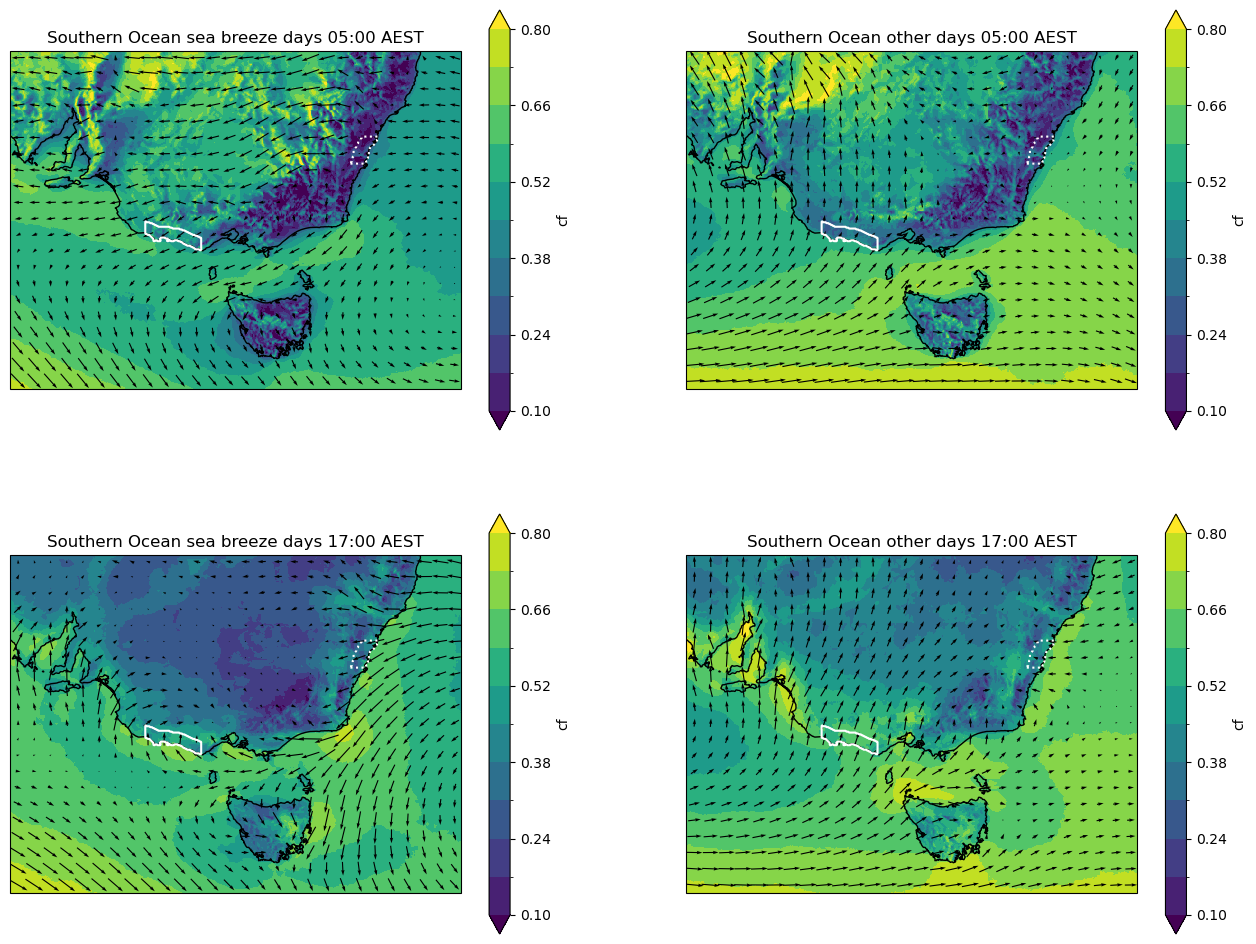

In [71]:
plt.figure(figsize=[16,12])

ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
plot_map(southern_sb.sel(season="DJF"),southern_non_sb.sel(season="DJF"),5,ax1,ax2,shapes,"southern_landsea","illawara_landsea")#,lat_slice=slice(-42,-27),lon_slice=slice(108,130))
ax1.set_title("Southern Ocean sea breeze days 05:00 AEST")
ax2.set_title("Southern Ocean other days 05:00 AEST")


ax1=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
ax2=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
plot_map(southern_sb.sel(season="DJF"),southern_non_sb.sel(season="DJF"),17,ax1,ax2,shapes,"southern_landsea","illawara_landsea")#,lat_slice=slice(-42,-27),lon_slice=slice(108,130))
ax1.set_title("Southern Ocean sea breeze days 17:00 AEST")
ax2.set_title("Southern Ocean other days 17:00 AEST")

In [14]:
gipps_sb

<xarray.Dataset> Size: 900MB
Dimensions:       (season: 5, hour: 24, lat: 375, lon: 500)
Coordinates:
  * lon           (lon) float64 4kB 135.0 135.1 135.1 ... 154.9 154.9 155.0
  * lat           (lat) float64 3kB -44.97 -44.93 -44.89 ... -30.05 -30.01
  * hour          (hour) int64 192B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
    height        float64 8B 100.0
    crs           int32 4B 0
  * season        (season) <U3 60B 'ANN' 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    u             (season, hour, lat, lon) float64 180MB dask.array<chunksize=(1, 24, 375, 500), meta=np.ndarray>
    v             (season, hour, lat, lon) float64 180MB dask.array<chunksize=(1, 24, 375, 500), meta=np.ndarray>
    ws            (season, hour, lat, lon) float64 180MB dask.array<chunksize=(1, 24, 375, 500), meta=np.ndarray>
    cf            (season, hour, lat, lon) float64 180MB dask.array<chunksize=(1, 24, 375, 500), meta=np.ndarray>
    tas           (season, hour, lat, lon) float64 180MB dask.array<chunksize=(1, 24, 375, 500), meta=np.ndarray>
    prop_sb_days  (season) float64 40B 0.3468 0.4199 0.2821 0.1031 0.3245
Attributes:
    months:   ['1979-01-01', '1979-02-01', '1979-03-01', '1979-04-01', '1979-...

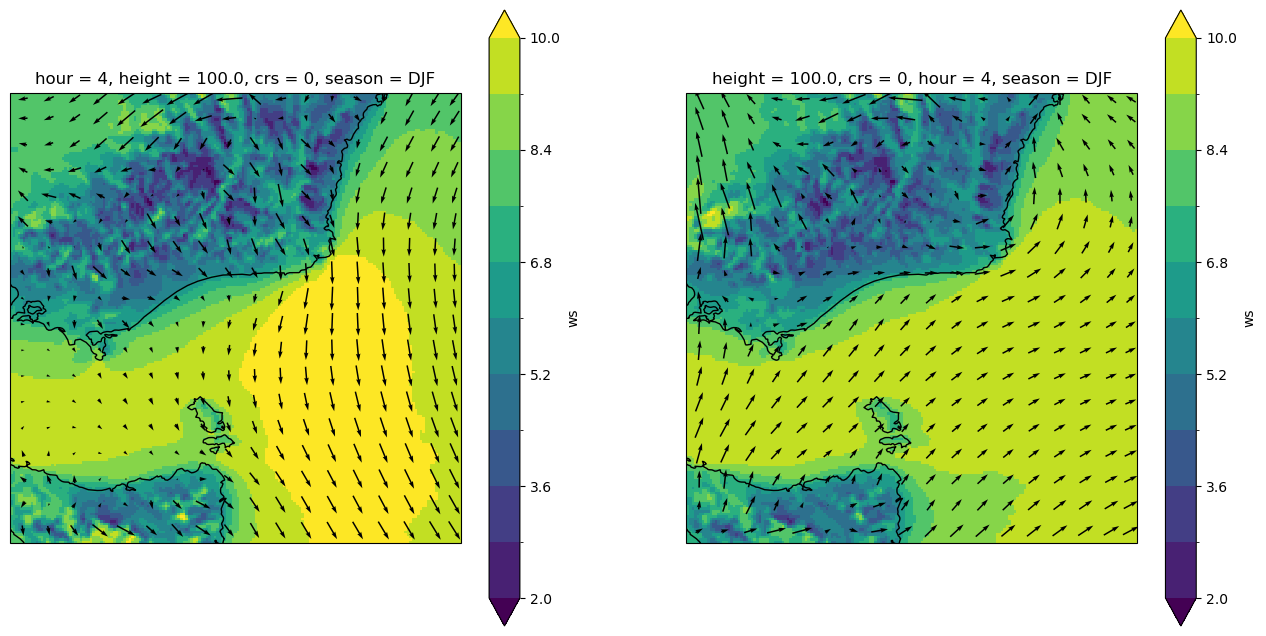

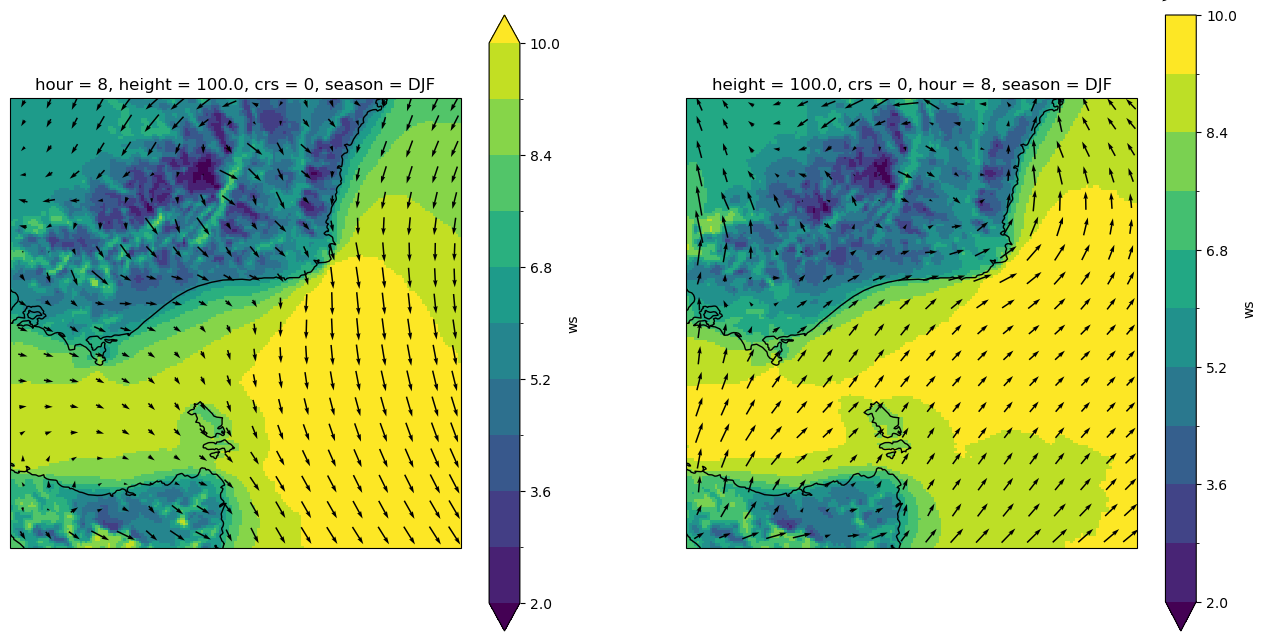

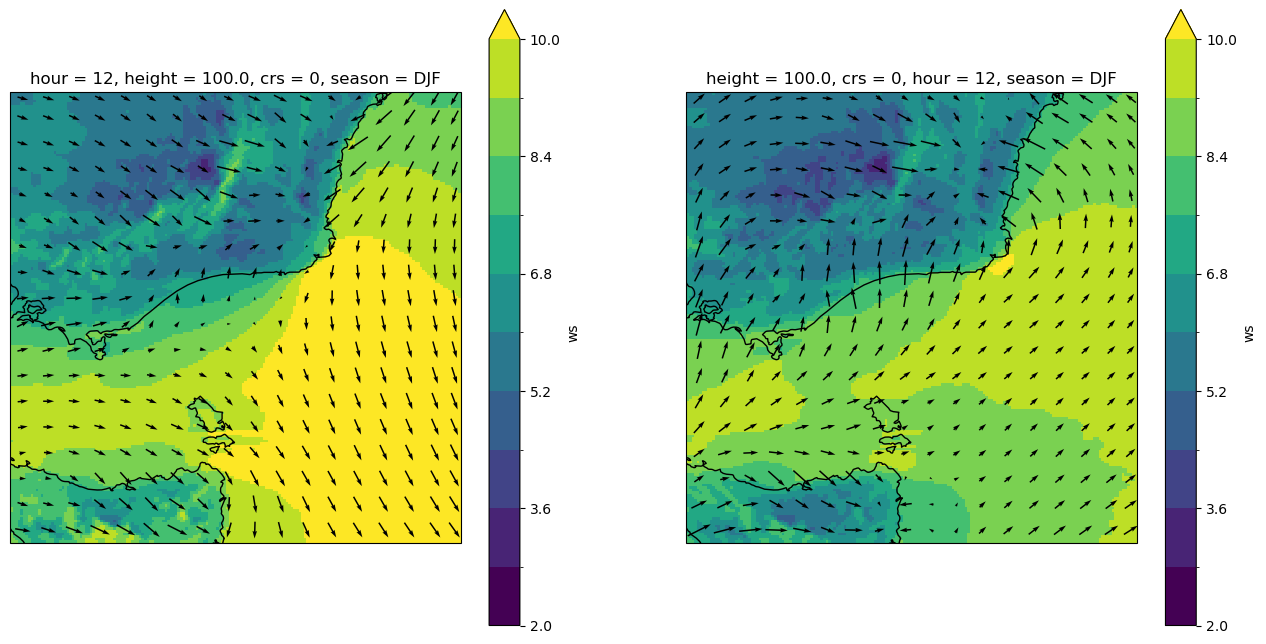

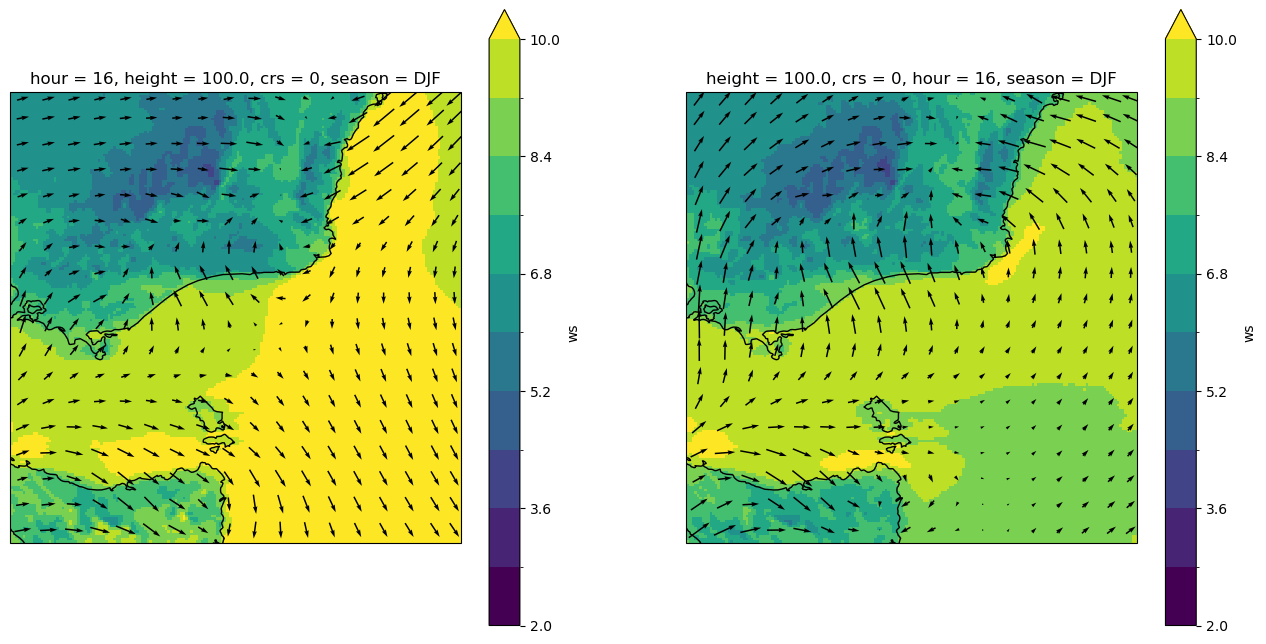

In [32]:
plot(sb.sel(season="DJF"),nonsb.sel(season="DJF"),4)
plot(sb.sel(season="DJF"),nonsb.sel(season="DJF"),8)
plot(sb.sel(season="DJF"),nonsb.sel(season="DJF"),12)
plot(sb.sel(season="DJF"),nonsb.sel(season="DJF"),16)

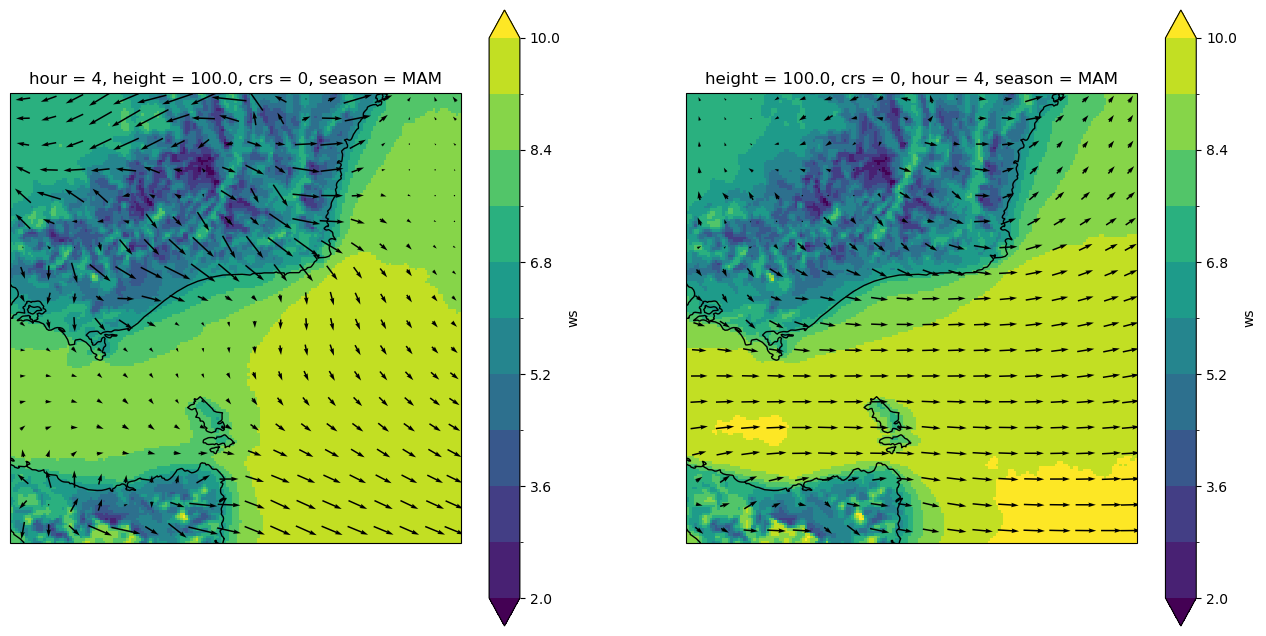

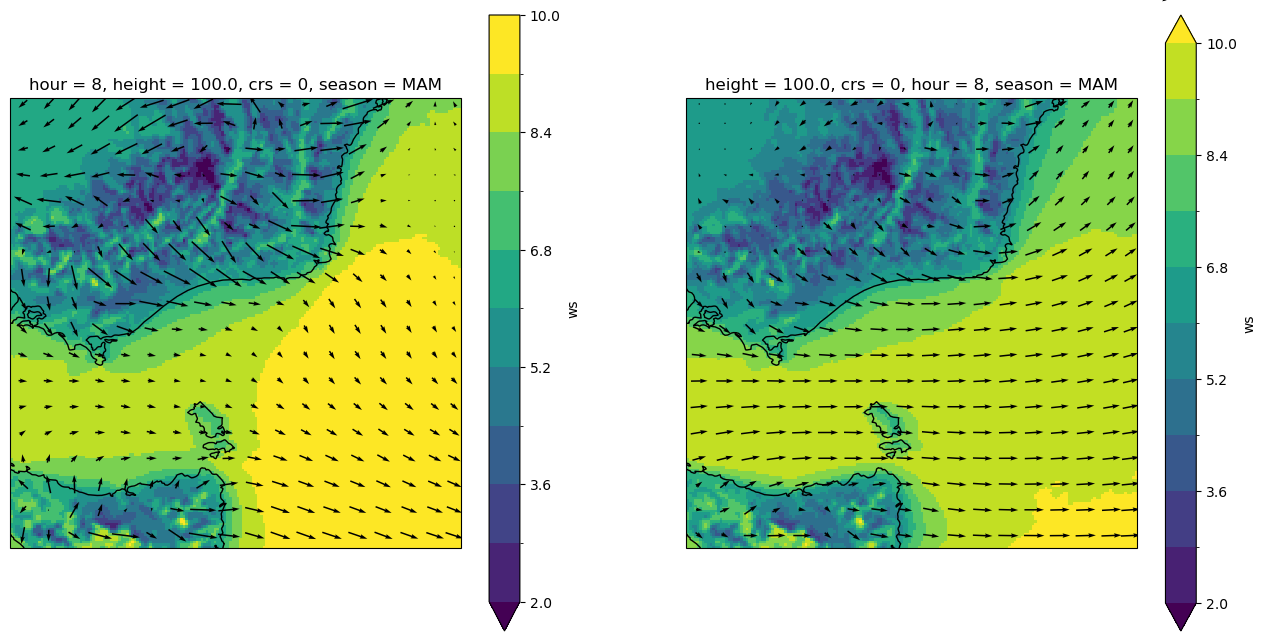

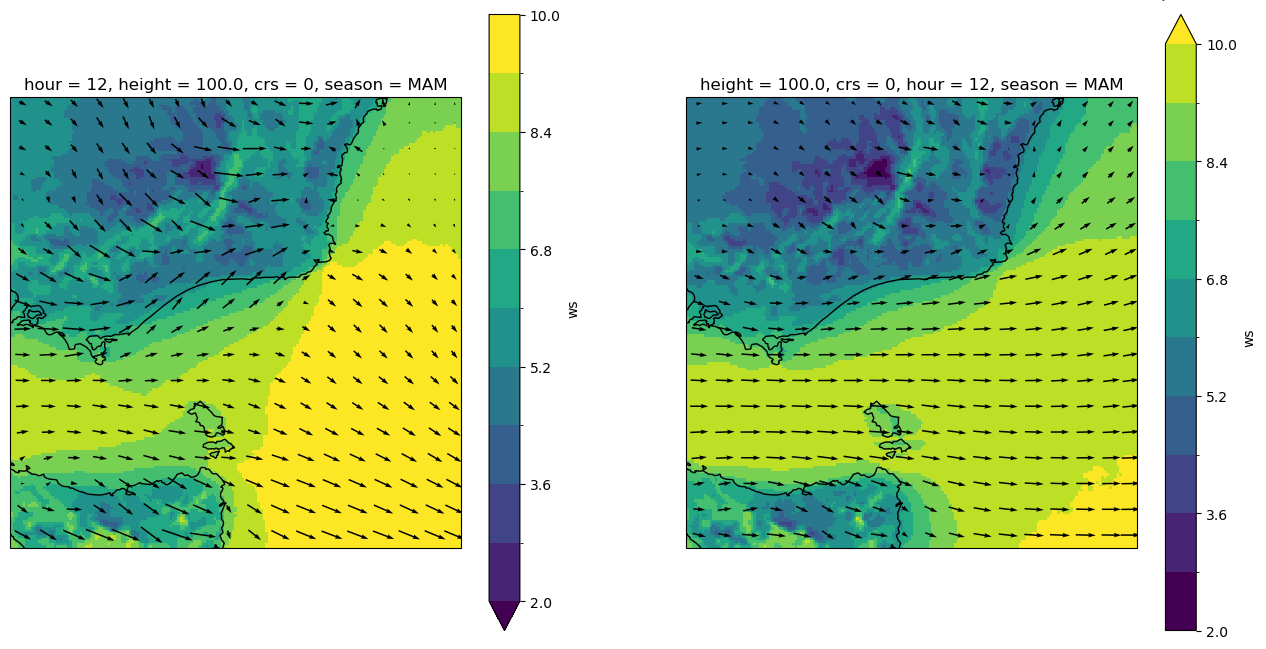

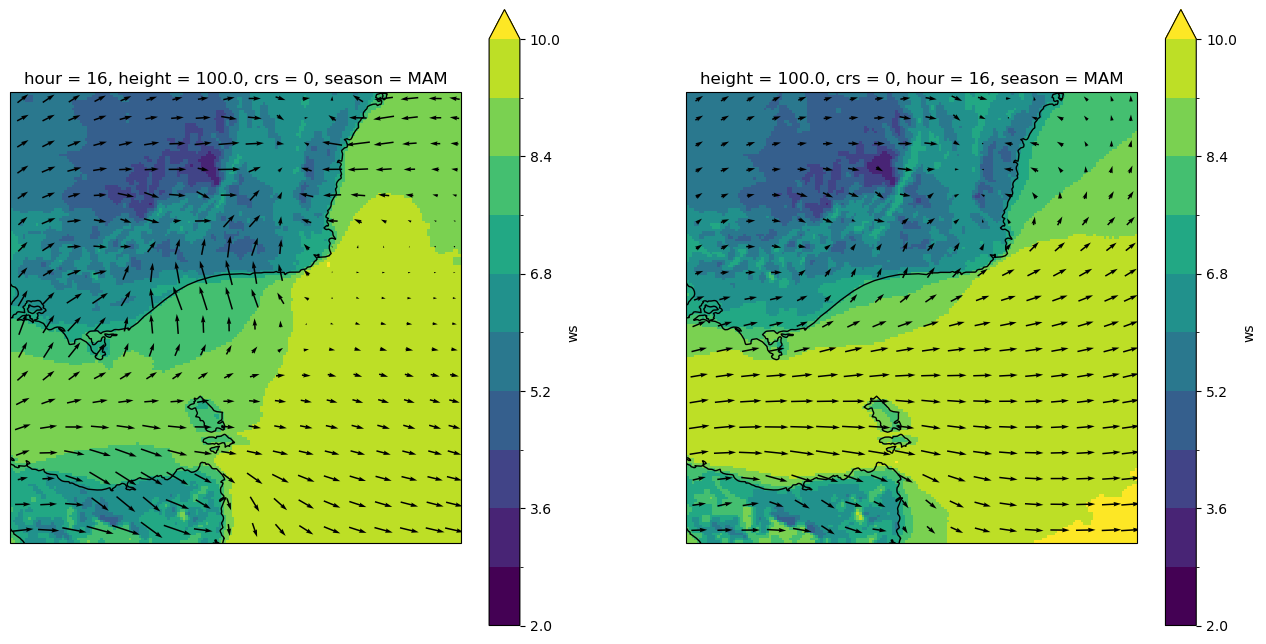

In [33]:
plot(sb.sel(season="MAM"),nonsb.sel(season="MAM"),4)
plot(sb.sel(season="MAM"),nonsb.sel(season="MAM"),8)
plot(sb.sel(season="MAM"),nonsb.sel(season="MAM"),12)
plot(sb.sel(season="MAM"),nonsb.sel(season="MAM"),16)

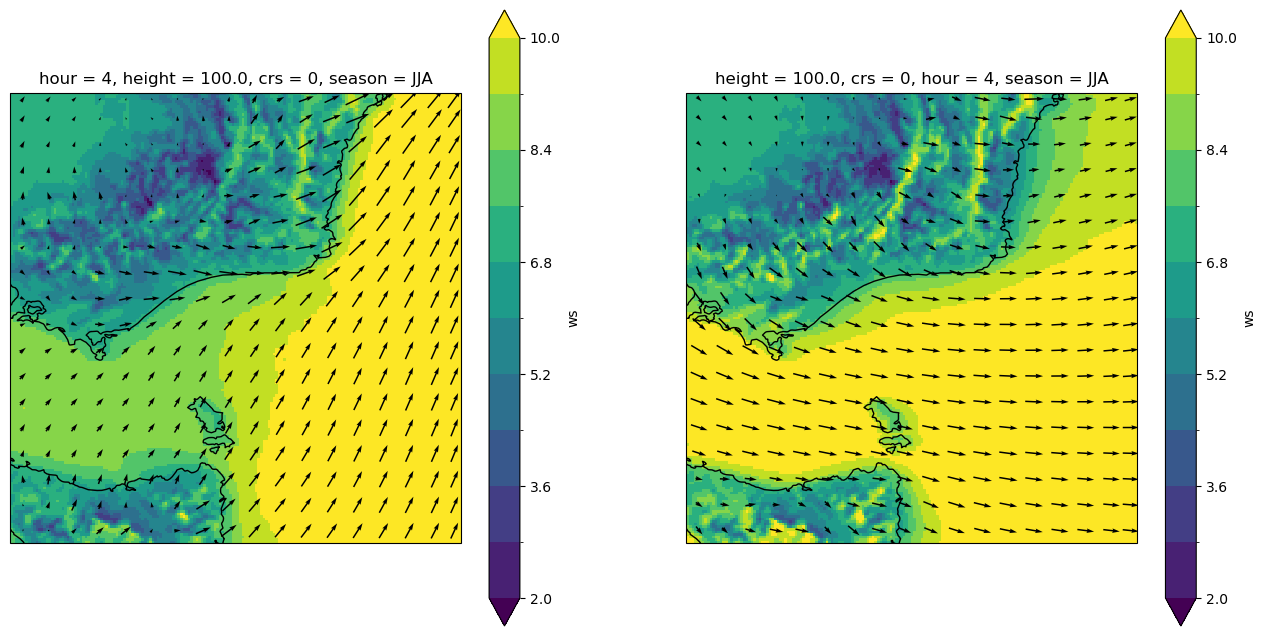

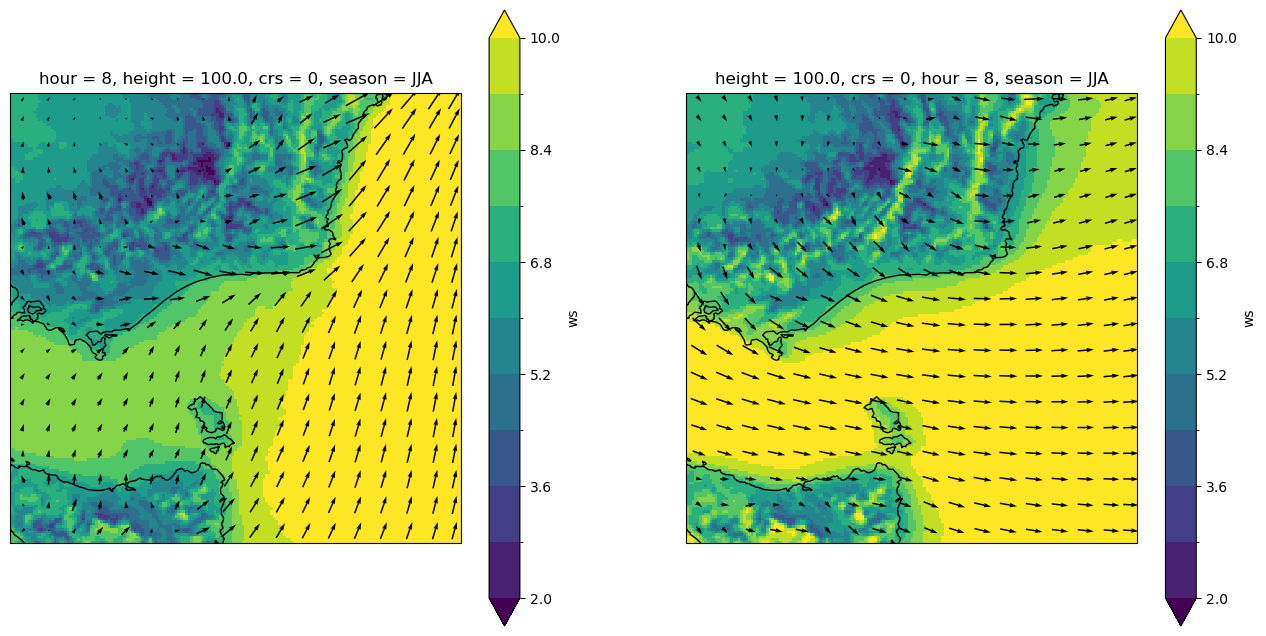

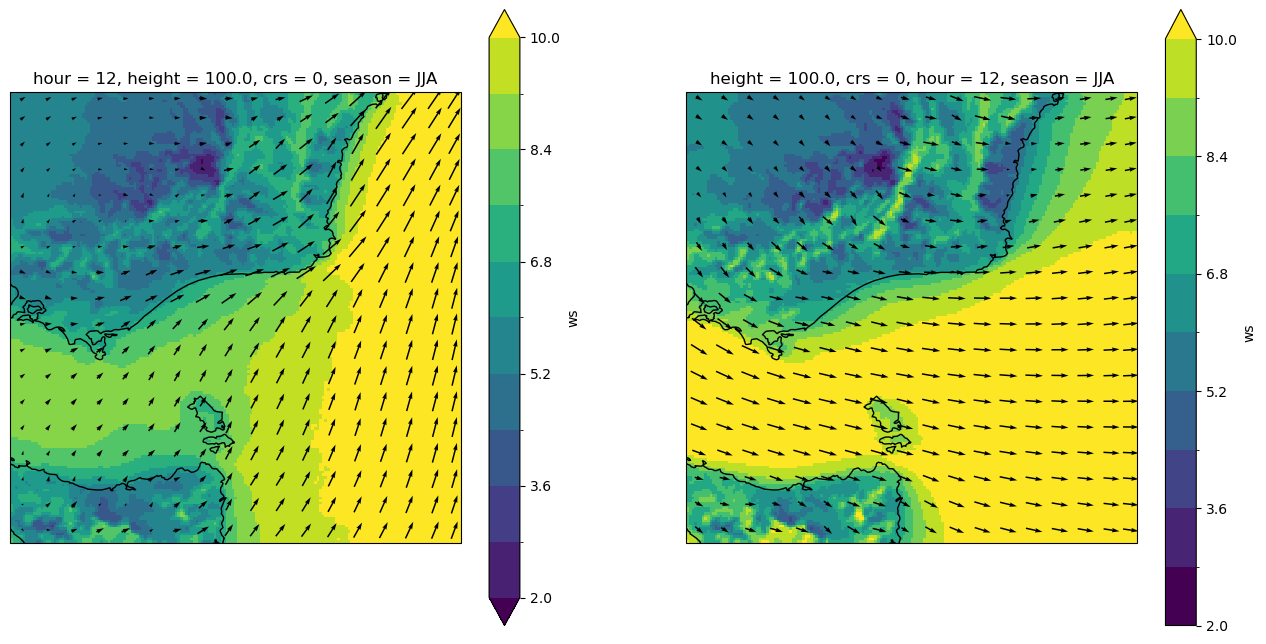

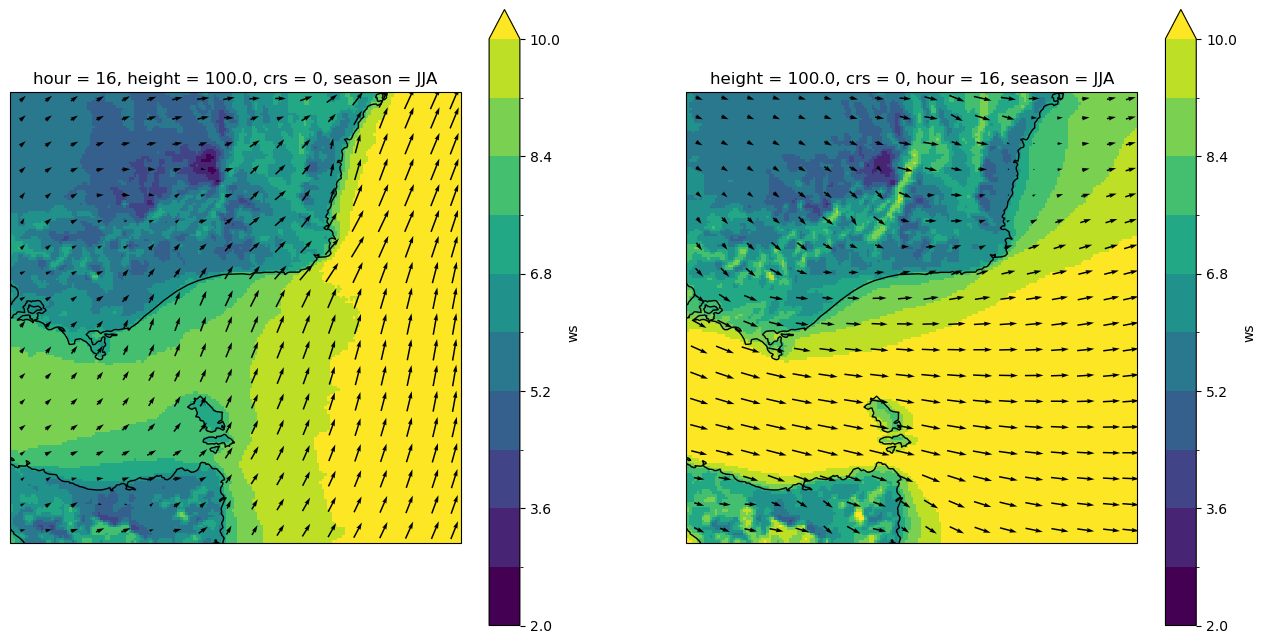

In [34]:
plot(sb.sel(season="JJA"),nonsb.sel(season="JJA"),4)
plot(sb.sel(season="JJA"),nonsb.sel(season="JJA"),8)
plot(sb.sel(season="JJA"),nonsb.sel(season="JJA"),12)
plot(sb.sel(season="JJA"),nonsb.sel(season="JJA"),16)

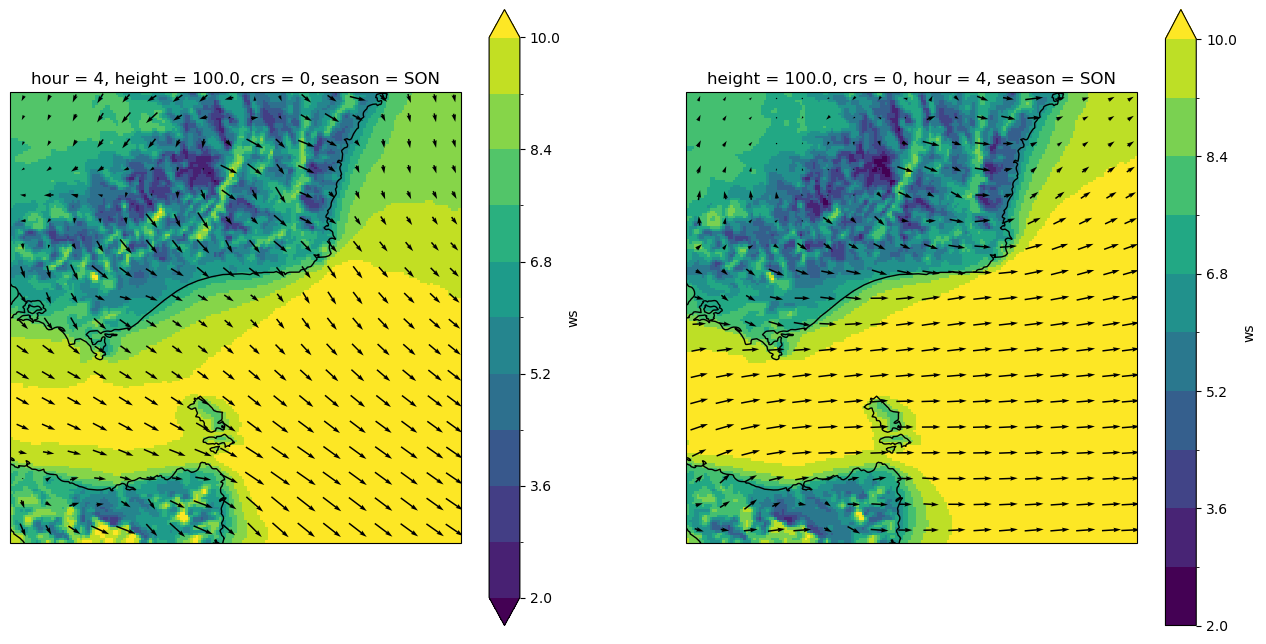

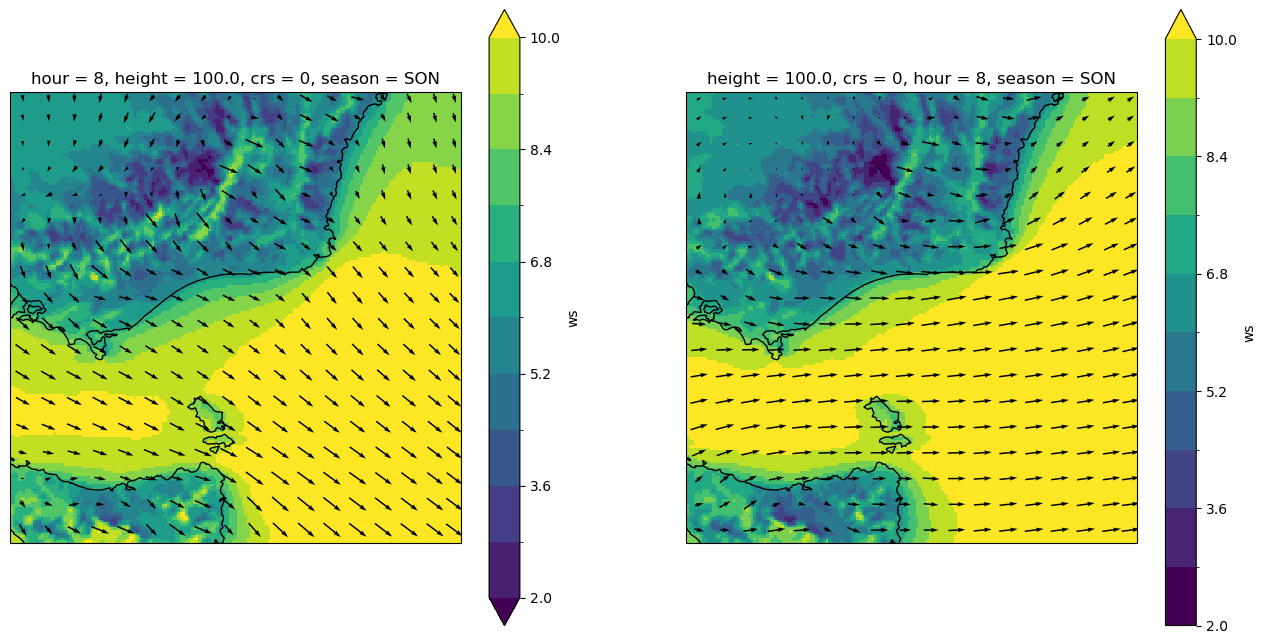

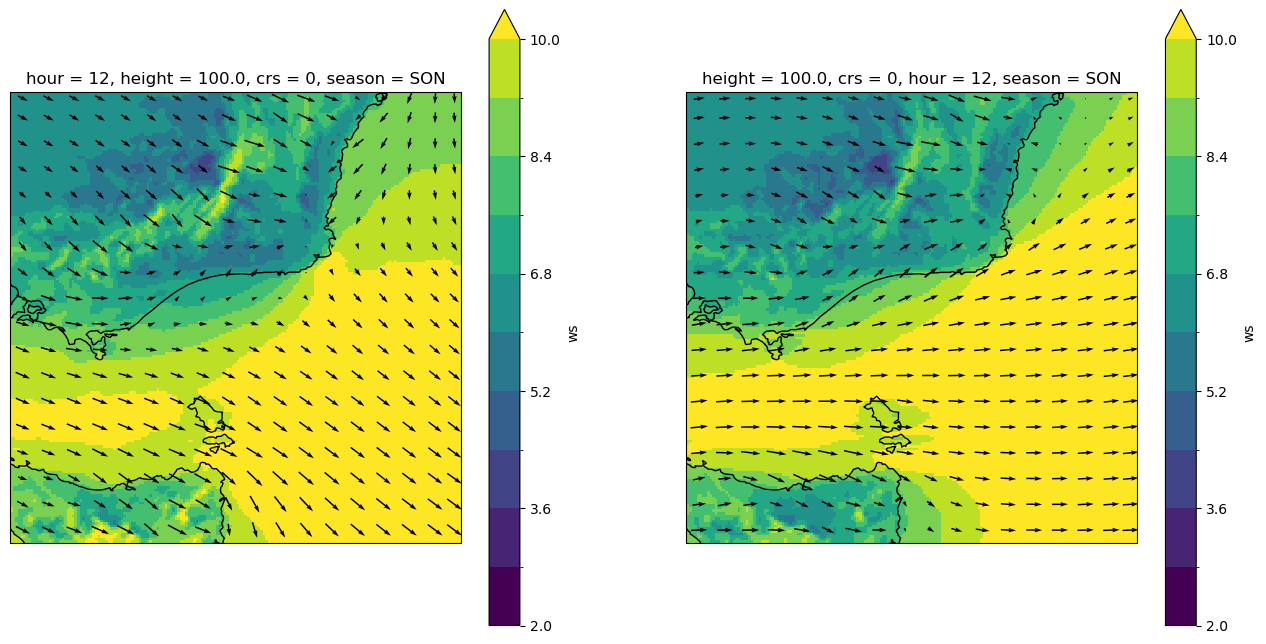

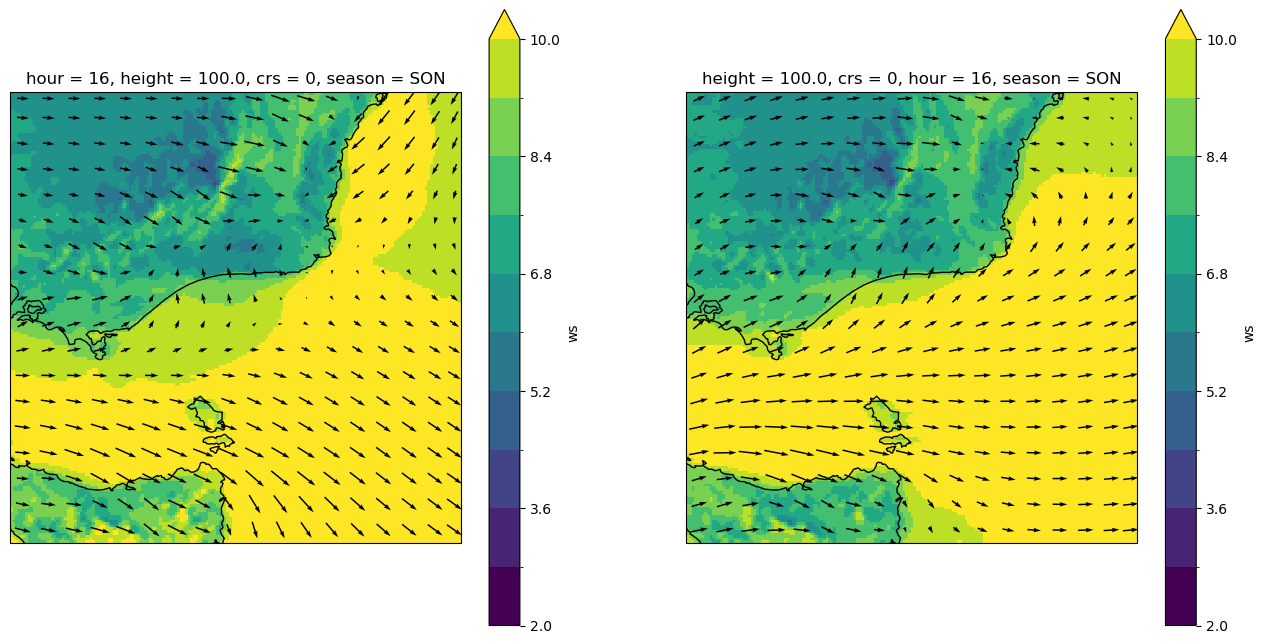

In [35]:
plot(sb.sel(season="SON"),nonsb.sel(season="SON"),4)
plot(sb.sel(season="SON"),nonsb.sel(season="SON"),8)
plot(sb.sel(season="SON"),nonsb.sel(season="SON"),12)
plot(sb.sel(season="SON"),nonsb.sel(season="SON"),16)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


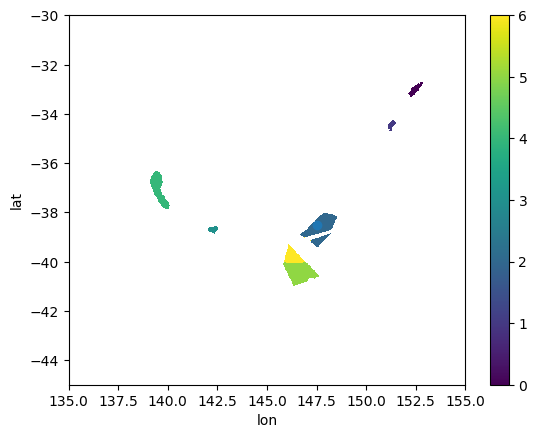

In [39]:
import geopandas as gpd
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

f=gpd.read_file("/g/data/ng72/ab4502/Indicative_REZ_boundaries_2024_GIS_data.kml")
rez_states = np.array([n[0] for n in f["Name"]])
offshore_inds = [18,19,27,28,38,42]
f = f.loc[offshore_inds]

#Match rez shapefile to barra-c grid

shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
raster = rasterize(shapes,{"lat":sb.lat,"lon":sb.lon},fill=np.nan)

xx,yy=np.meshgrid(raster.lon,raster.lat)
#Split the Vic Gippsland offshore REZ into two
raster = xr.where(((raster==2) & (xx<147.2) & (yy<-39)), raster.max()+1, raster)

raster.plot()
plt.plot(147.5,-38.5,marker="o")

(0.4, 0.7)

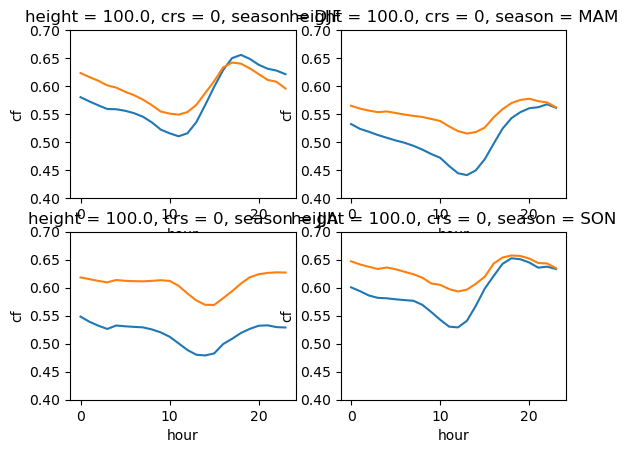

In [37]:
plt.subplot(2,2,1)
xr.where((raster==2),sb.sel(season="DJF"),np.nan).mean(("lat","lon")).cf.plot()
xr.where((raster==2),nonsb.sel(season="DJF"),np.nan).mean(("lat","lon")).cf.plot()
plt.ylim([0.4,0.7])

plt.subplot(2,2,2)
xr.where((raster==2),sb.sel(season="MAM"),np.nan).mean(("lat","lon")).cf.plot()
xr.where((raster==2),nonsb.sel(season="MAM"),np.nan).mean(("lat","lon")).cf.plot()
plt.ylim([0.4,0.7])

plt.subplot(2,2,3)
xr.where((raster==2),sb.sel(season="JJA"),np.nan).mean(("lat","lon")).cf.plot()
xr.where((raster==2),nonsb.sel(season="JJA"),np.nan).mean(("lat","lon")).cf.plot()
plt.ylim([0.4,0.7])

plt.subplot(2,2,4)
xr.where((raster==2),sb.sel(season="SON"),np.nan).mean(("lat","lon")).cf.plot()
xr.where((raster==2),nonsb.sel(season="SON"),np.nan).mean(("lat","lon")).cf.plot()
plt.ylim([0.4,0.7])

# plt.figure()
# xr.where((raster==2),sb.sel(season="ANN"),np.nan).mean(("lat","lon")).u.plot()
# xr.where((raster==2),nonsb.sel(season="ANN"),np.nan).mean(("lat","lon")).u.plot()

# plt.figure()
# xr.where((raster==2),sb.sel(season="ANN"),np.nan).mean(("lat","lon")).v.plot()
# xr.where((raster==2),nonsb.sel(season="ANN"),np.nan).mean(("lat","lon")).v.plot()

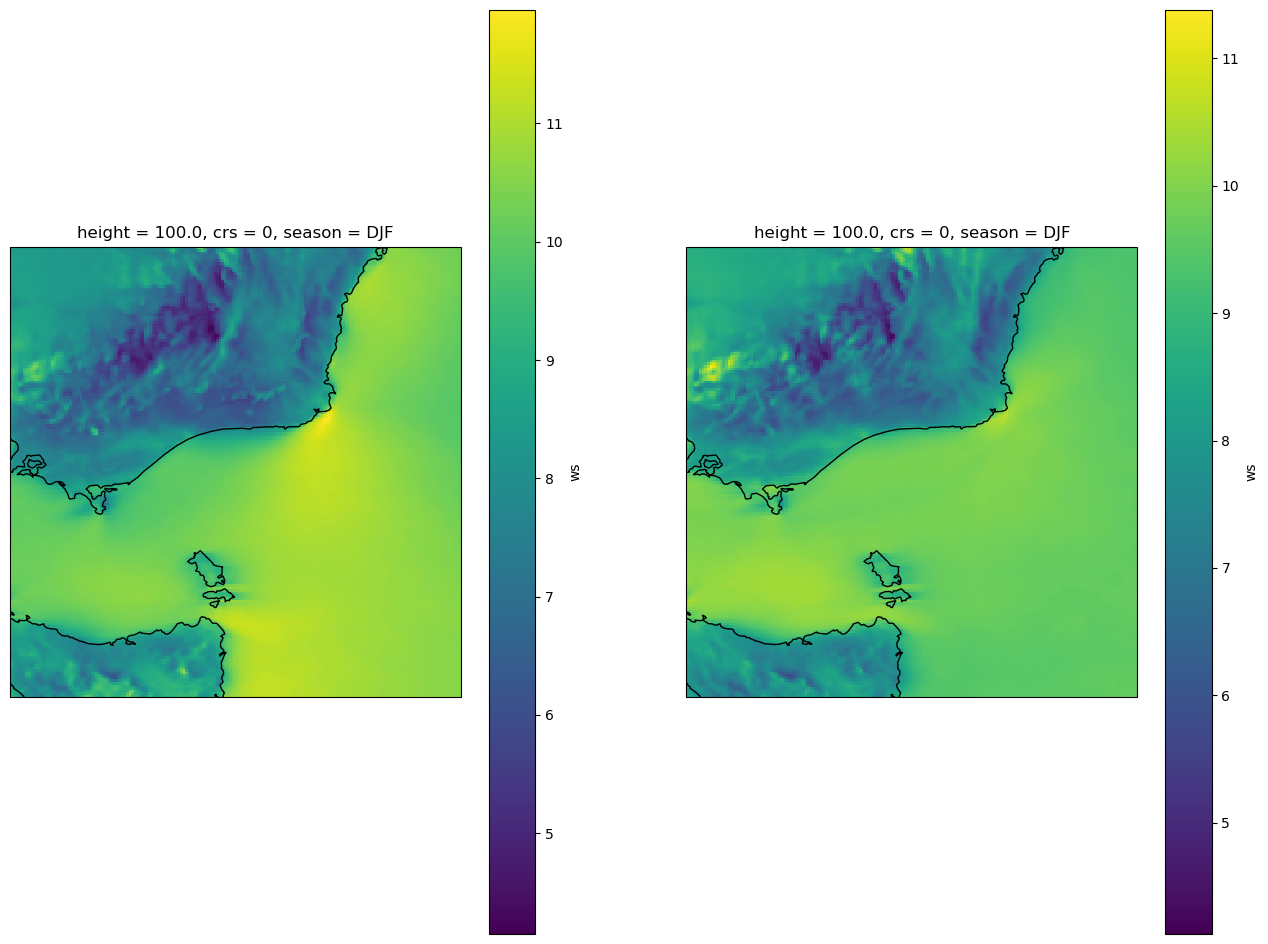

In [57]:
lon_slice=slice(145,152)
lat_slice=slice(-42,-35)

plt.figure(figsize=[16,12])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
(sb.sel(season="DJF",lat=lat_slice,lon=lon_slice).ws.max("hour")).plot()
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
(nonsb.sel(season="DJF",lat=lat_slice,lon=lon_slice).ws.max("hour")).plot()
ax.coastlines()